# ATML Assignment 1 - Task 2: Investigating VAE vs. GAN Biases
This notebook presents a comprehensive analysis of the inductive biases in two prominent generative models: the Variational Autoencoder (VAE) and the Deep Convolutional Generative Adversarial Network (DCGAN). Using the CIFAR-10 dataset, we will train both models from scratch and conduct a series of experiments to compare their fundamental differences.

The investigation will cover:

Output Quality and Diversity: A visual and quantitative comparison of the models' ability to generate high-fidelity images while covering the data distribution.

Latent Space Structure: An exploration of how each model organizes data in its latent space, tested through interpolation and representation analysis.

Out-of-Distribution (OOD) Handling: An evaluation of how each model responds to unseen data, revealing their underlying assumptions about the input distribution.

The ultimate goal is to connect these empirical findings back to the models' core architectures and training objectives, highlighting the inherent trade-offs between them, such as fidelity versus diversity.

# Step 1. Train/Obtain Models

In this step, we train both a VAE and DCGAN on CIFAR-10 to establish the foundation for comparing their inductive biases through their different training objectives and stability patterns.

## 1. Setup and Imports

In [1]:
import os
import shutil
import warnings

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch_fidelity import calculate_metrics
from torchvision.models.resnet import Bottleneck
from torchvision.utils import make_grid

os.environ["TQDM_NOTEBOOK"] = "0"
from tqdm import tqdm

# --- Configuration ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Create a directory to save models
os.makedirs("models", exist_ok=True)

warnings.filterwarnings("ignore", category=UserWarning, module="torch_fidelity")

# Hyperparameters
BATCH_SIZE = 256
LEARNING_RATE_VAE = 1e-3
LEARNING_RATE_GAN = 4e-4
EPOCHS_VAE = 25
EPOCHS_GAN = 50
LATENT_DIM = 128
IMG_CHANNELS = 3
IMG_SIZE = 32

Using device: cuda


## 2. Data Loading
We'll load the CIFAR-10 dataset. The images are normalized to the range `[-1, 1]` which is standard for GANs with a `Tanh` output.

In [2]:
transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),  # Normalize to [-1, 1]
    ]
)

train_dataset = torchvision.datasets.CIFAR10(
    root="./data", train=True, download=True, transform=transform
)
train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)


def imshow(img):
    img = img / 2 + 0.5  # Unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

## 3. Part 1: Variational Autoencoder (VAE)

### VAE Model Definition
A basic convolutional VAE for 32x32 images. The encoder outputs the parameters of a latent Gaussian distribution (`mu` and `log_var`), and the decoder samples from this distribution to reconstruct the image[cite: 154, 155].

In [3]:
class VAE(nn.Module):
    def __init__(self, img_channels=3, latent_dim=128):
        super(VAE, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            # 32x32x3 -> 16x16x64
            nn.Conv2d(img_channels, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),
            # 16x16x64 -> 8x8x128
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            # 8x8x128 -> 4x4x256
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Flatten(),
        )

        self.fc_mu = nn.Linear(256 * 4 * 4, latent_dim)
        self.fc_log_var = nn.Linear(256 * 4 * 4, latent_dim)

        # Decoder input
        self.decoder_input = nn.Linear(latent_dim, 256 * 4 * 4)

        # Decoder
        self.decoder = nn.Sequential(
            # 4x4x256 -> 8x8x128
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            # 8x8x128 -> 16x16x64
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            # 16x16x64 -> 32x32x3
            nn.ConvTranspose2d(64, img_channels, kernel_size=4, stride=2, padding=1),
            nn.Tanh(),
        )

    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        x_encoded = self.encoder(x)
        mu = self.fc_mu(x_encoded)
        log_var = self.fc_log_var(x_encoded)
        z = self.reparameterize(mu, log_var)
        x_reconstructed = self.decoder_input(z)
        x_reconstructed = self.decoder(x_reconstructed.view(-1, 256, 4, 4))
        return x_reconstructed, mu, log_var

    def reconstruct(self, x, deterministic: bool = True):
        x_encoded = self.encoder(x)
        mu = self.fc_mu(x_encoded)
        log_var = self.fc_log_var(x_encoded)
        z = mu if deterministic else self.reparameterize(mu, log_var)
        x_rec = self.decoder_input(z)
        x_rec = self.decoder(x_rec.view(-1, 256, 4, 4))  # keep your shapes
        return x_rec, mu, log_var


def vae_loss_function(recon_x, x, mu, log_var, beta):
    recon_loss = nn.functional.mse_loss(recon_x, x, reduction="mean")
    kl_div = -0.5 * torch.mean(1 + log_var - mu.pow(2) - log_var.exp())
    return recon_loss + beta * kl_div

### VAE Training

In [4]:
vae = VAE(img_channels=IMG_CHANNELS, latent_dim=LATENT_DIM).to(device)
optimizer_vae = optim.Adam(vae.parameters(), lr=LEARNING_RATE_VAE)

vae_losses = []

print("--- Starting VAE Training ---")
for epoch in range(EPOCHS_VAE):
    total_loss = 0
    for batch_idx, (real_images, _) in enumerate(
        tqdm(train_loader, desc=f"VAE Epoch {epoch+1} out of {EPOCHS_VAE}")
    ):
        real_images = real_images.to(device)

        # Forward pass
        recon_images, mu, log_var = vae(real_images)

        # Calculate loss
        loss = vae_loss_function(recon_images, real_images, mu, log_var, beta=0.001)
        total_loss += loss.item()

        # Backward pass and optimization
        optimizer_vae.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(vae.parameters(), max_norm=1.0)
        optimizer_vae.step()

    avg_loss = total_loss / len(train_loader.dataset)
    vae_losses.append(avg_loss)
    print(
        f"Epoch [{epoch+1} out of {EPOCHS_VAE}], Loss: {total_loss/len(train_loader.dataset):.4f}"
    )
print("--- VAE Training Finished ---")

--- Starting VAE Training ---


VAE Epoch 1 out of 25: 100%|██████████| 196/196 [00:13<00:00, 14.68it/s]


Epoch [1 out of 25], Loss: 0.0181


VAE Epoch 2 out of 25: 100%|██████████| 196/196 [00:11<00:00, 16.89it/s]


Epoch [2 out of 25], Loss: 0.0002


VAE Epoch 3 out of 25: 100%|██████████| 196/196 [00:11<00:00, 16.83it/s]


Epoch [3 out of 25], Loss: 0.0001


VAE Epoch 4 out of 25: 100%|██████████| 196/196 [00:11<00:00, 16.91it/s]


Epoch [4 out of 25], Loss: 0.0001


VAE Epoch 5 out of 25: 100%|██████████| 196/196 [00:11<00:00, 16.61it/s]


Epoch [5 out of 25], Loss: 0.0001


VAE Epoch 6 out of 25: 100%|██████████| 196/196 [00:11<00:00, 16.69it/s]


Epoch [6 out of 25], Loss: 0.0001


VAE Epoch 7 out of 25: 100%|██████████| 196/196 [00:11<00:00, 16.86it/s]


Epoch [7 out of 25], Loss: 0.0001


VAE Epoch 8 out of 25: 100%|██████████| 196/196 [00:12<00:00, 16.19it/s]


Epoch [8 out of 25], Loss: 0.0001


VAE Epoch 9 out of 25: 100%|██████████| 196/196 [00:11<00:00, 16.48it/s]


Epoch [9 out of 25], Loss: 0.0001


VAE Epoch 10 out of 25: 100%|██████████| 196/196 [00:11<00:00, 16.78it/s]


Epoch [10 out of 25], Loss: 0.0001


VAE Epoch 11 out of 25: 100%|██████████| 196/196 [00:11<00:00, 16.64it/s]


Epoch [11 out of 25], Loss: 0.0001


VAE Epoch 12 out of 25: 100%|██████████| 196/196 [00:11<00:00, 16.43it/s]


Epoch [12 out of 25], Loss: 0.0001


VAE Epoch 13 out of 25: 100%|██████████| 196/196 [00:12<00:00, 16.12it/s]


Epoch [13 out of 25], Loss: 0.0001


VAE Epoch 14 out of 25: 100%|██████████| 196/196 [00:12<00:00, 16.25it/s]


Epoch [14 out of 25], Loss: 0.0001


VAE Epoch 15 out of 25: 100%|██████████| 196/196 [00:11<00:00, 16.82it/s]


Epoch [15 out of 25], Loss: 0.0001


VAE Epoch 16 out of 25: 100%|██████████| 196/196 [00:11<00:00, 16.94it/s]


Epoch [16 out of 25], Loss: 0.0001


VAE Epoch 17 out of 25: 100%|██████████| 196/196 [00:11<00:00, 17.10it/s]


Epoch [17 out of 25], Loss: 0.0001


VAE Epoch 18 out of 25: 100%|██████████| 196/196 [00:11<00:00, 16.73it/s]


Epoch [18 out of 25], Loss: 0.0001


VAE Epoch 19 out of 25: 100%|██████████| 196/196 [00:12<00:00, 16.03it/s]


Epoch [19 out of 25], Loss: 0.0001


VAE Epoch 20 out of 25: 100%|██████████| 196/196 [00:11<00:00, 16.51it/s]


Epoch [20 out of 25], Loss: 0.0001


VAE Epoch 21 out of 25: 100%|██████████| 196/196 [00:11<00:00, 16.79it/s]


Epoch [21 out of 25], Loss: 0.0001


VAE Epoch 22 out of 25: 100%|██████████| 196/196 [00:11<00:00, 16.91it/s]


Epoch [22 out of 25], Loss: 0.0001


VAE Epoch 23 out of 25: 100%|██████████| 196/196 [00:11<00:00, 16.76it/s]


Epoch [23 out of 25], Loss: 0.0001


VAE Epoch 24 out of 25: 100%|██████████| 196/196 [00:11<00:00, 16.47it/s]


Epoch [24 out of 25], Loss: 0.0001


VAE Epoch 25 out of 25: 100%|██████████| 196/196 [00:11<00:00, 16.71it/s]

Epoch [25 out of 25], Loss: 0.0001
--- VAE Training Finished ---


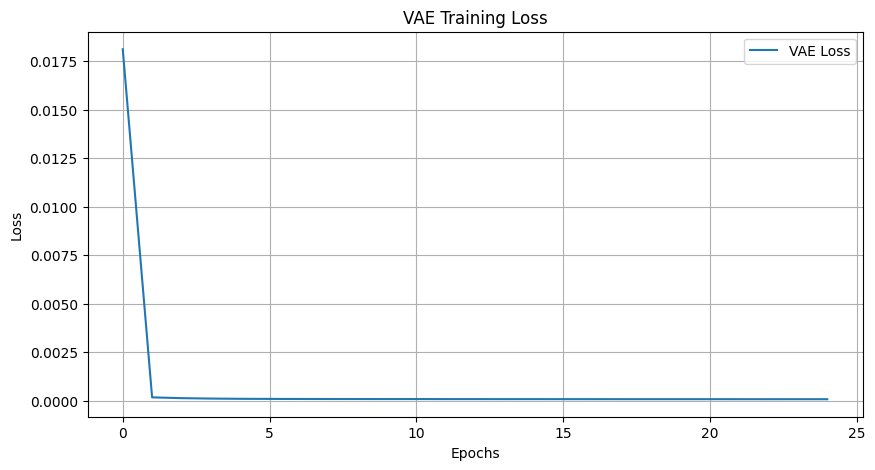

In [5]:
plt.figure(figsize=(10, 5))
plt.plot(vae_losses, label="VAE Loss")
plt.title("VAE Training Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

## 4. Part 2: Deep Convolutional Generative Adversarial Network (DCGAN)

### DCGAN Model Definition
The Generator network upsamples a latent vector into an image. The Discriminator network classifies an image as real or fake[cite: 156].

In [4]:
class Discriminator(nn.Module):
    def __init__(self, img_channels=3):
        super(Discriminator, self).__init__()
        self.net = nn.Sequential(
            # Input: 3 x 32 x 32
            nn.Conv2d(img_channels, 64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # State: 64 x 16 x 16
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            # State: 128 x 8 x 8
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            # State: 256 x 4 x 4
            nn.Conv2d(256, 1, kernel_size=4, stride=1, padding=0, bias=False),
            nn.Sigmoid(),
        )

    def forward(self, x):
        return self.net(x).view(-1, 1).squeeze(1)


class Generator(nn.Module):
    def __init__(self, latent_dim, img_channels=3):
        super(Generator, self).__init__()
        self.net = nn.Sequential(
            # Input: latent_dim
            nn.ConvTranspose2d(
                latent_dim, 256, kernel_size=4, stride=1, padding=0, bias=False
            ),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            # State: 256 x 4 x 4
            nn.ConvTranspose2d(
                256, 128, kernel_size=4, stride=2, padding=1, bias=False
            ),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            # State: 128 x 8 x 8
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            # State: 64 x 16 x 16
            nn.ConvTranspose2d(
                64, img_channels, kernel_size=4, stride=2, padding=1, bias=False
            ),
            nn.Tanh(),  # Output: 3 x 32 x 32
        )

    def forward(self, x):
        return self.net(x)


def weights_init(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find("BatchNorm") != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

### DCGAN Training

In [7]:
discriminator = Discriminator(IMG_CHANNELS).to(device)
discriminator.apply(weights_init)
generator = Generator(LATENT_DIM, IMG_CHANNELS).to(device)
generator.apply(weights_init)

optimizer_D = optim.Adam(
    discriminator.parameters(), lr=LEARNING_RATE_GAN, betas=(0.5, 0.999)
)
optimizer_G = optim.Adam(
    generator.parameters(), lr=LEARNING_RATE_GAN, betas=(0.5, 0.999)
)
criterion = nn.BCELoss()

d_losses = []
g_losses = []

print("--- Starting DCGAN Training ---")
for epoch in range(EPOCHS_GAN):
    for batch_idx, (real_images, _) in enumerate(
        tqdm(train_loader, desc=f"DCGAN Epoch {epoch+1} out of {EPOCHS_GAN}")
    ):
        real_images = real_images.to(device)
        batch_size = real_images.size(0)

        # --- Train Discriminator ---
        discriminator.zero_grad()

        # Train with real images
        label = torch.full((batch_size,), 1.0, dtype=torch.float, device=device)
        output = discriminator(real_images)
        loss_D_real = criterion(output, label)
        loss_D_real.backward()

        # Train with fake images
        noise = torch.randn(batch_size, LATENT_DIM, 1, 1, device=device)
        fake_images = generator(noise)
        label.fill_(0.0)
        output = discriminator(
            fake_images.detach()
        )  # .detach() to avoid gradients flowing to generator
        loss_D_fake = criterion(output, label)
        loss_D_fake.backward()

        loss_D = loss_D_real + loss_D_fake
        optimizer_D.step()

        # --- Train Generator ---
        generator.zero_grad()
        label.fill_(1.0)  # Generator wants discriminator to think fake images are real
        output = discriminator(fake_images)
        loss_G = criterion(output, label)
        loss_G.backward()
        optimizer_G.step()

    d_losses.append(loss_D.item())
    g_losses.append(loss_G.item())

    print(
        f"Epoch [{epoch+1} out of {EPOCHS_GAN}], Loss D: {loss_D.item():.4f}, Loss G: {loss_G.item():.4f}"
    )

print("--- DCGAN Training Finished ---")

--- Starting DCGAN Training ---


DCGAN Epoch 1 out of 50: 100%|██████████| 196/196 [00:15<00:00, 12.36it/s]


Epoch [1 out of 50], Loss D: 0.9868, Loss G: 4.1639


DCGAN Epoch 2 out of 50: 100%|██████████| 196/196 [00:15<00:00, 12.67it/s]


Epoch [2 out of 50], Loss D: 0.4141, Loss G: 3.6483


DCGAN Epoch 3 out of 50: 100%|██████████| 196/196 [00:15<00:00, 12.56it/s]


Epoch [3 out of 50], Loss D: 0.4343, Loss G: 4.0076


DCGAN Epoch 4 out of 50: 100%|██████████| 196/196 [00:15<00:00, 13.01it/s]


Epoch [4 out of 50], Loss D: 0.8504, Loss G: 2.7098


DCGAN Epoch 5 out of 50: 100%|██████████| 196/196 [00:14<00:00, 13.44it/s]


Epoch [5 out of 50], Loss D: 0.6649, Loss G: 3.8417


DCGAN Epoch 6 out of 50: 100%|██████████| 196/196 [00:14<00:00, 13.28it/s]


Epoch [6 out of 50], Loss D: 0.6912, Loss G: 1.5007


DCGAN Epoch 7 out of 50: 100%|██████████| 196/196 [00:14<00:00, 13.39it/s]


Epoch [7 out of 50], Loss D: 0.7018, Loss G: 2.3900


DCGAN Epoch 8 out of 50: 100%|██████████| 196/196 [00:14<00:00, 13.23it/s]


Epoch [8 out of 50], Loss D: 0.8951, Loss G: 2.5288


DCGAN Epoch 9 out of 50: 100%|██████████| 196/196 [00:14<00:00, 13.25it/s]


Epoch [9 out of 50], Loss D: 0.9002, Loss G: 3.5363


DCGAN Epoch 10 out of 50: 100%|██████████| 196/196 [00:14<00:00, 13.44it/s]


Epoch [10 out of 50], Loss D: 0.8358, Loss G: 2.5749


DCGAN Epoch 11 out of 50: 100%|██████████| 196/196 [00:14<00:00, 13.34it/s]


Epoch [11 out of 50], Loss D: 1.1596, Loss G: 2.7490


DCGAN Epoch 12 out of 50: 100%|██████████| 196/196 [00:14<00:00, 13.34it/s]


Epoch [12 out of 50], Loss D: 0.9748, Loss G: 2.9944


DCGAN Epoch 13 out of 50: 100%|██████████| 196/196 [00:15<00:00, 13.07it/s]


Epoch [13 out of 50], Loss D: 1.0849, Loss G: 1.2676


DCGAN Epoch 14 out of 50: 100%|██████████| 196/196 [00:15<00:00, 12.58it/s]


Epoch [14 out of 50], Loss D: 1.4125, Loss G: 4.1695


DCGAN Epoch 15 out of 50: 100%|██████████| 196/196 [00:15<00:00, 12.56it/s]


Epoch [15 out of 50], Loss D: 0.6452, Loss G: 2.8846


DCGAN Epoch 16 out of 50: 100%|██████████| 196/196 [00:15<00:00, 12.58it/s]


Epoch [16 out of 50], Loss D: 0.6689, Loss G: 2.1571


DCGAN Epoch 17 out of 50: 100%|██████████| 196/196 [00:15<00:00, 12.48it/s]


Epoch [17 out of 50], Loss D: 0.5443, Loss G: 2.4797


DCGAN Epoch 18 out of 50: 100%|██████████| 196/196 [00:15<00:00, 12.57it/s]


Epoch [18 out of 50], Loss D: 1.2390, Loss G: 0.8980


DCGAN Epoch 19 out of 50: 100%|██████████| 196/196 [00:15<00:00, 12.51it/s]


Epoch [19 out of 50], Loss D: 0.9233, Loss G: 2.1337


DCGAN Epoch 20 out of 50: 100%|██████████| 196/196 [00:15<00:00, 12.55it/s]


Epoch [20 out of 50], Loss D: 0.6814, Loss G: 2.4575


DCGAN Epoch 21 out of 50: 100%|██████████| 196/196 [00:15<00:00, 12.58it/s]


Epoch [21 out of 50], Loss D: 0.9333, Loss G: 2.1692


DCGAN Epoch 22 out of 50: 100%|██████████| 196/196 [00:15<00:00, 12.65it/s]


Epoch [22 out of 50], Loss D: 1.4120, Loss G: 3.6663


DCGAN Epoch 23 out of 50: 100%|██████████| 196/196 [00:15<00:00, 12.76it/s]


Epoch [23 out of 50], Loss D: 1.1459, Loss G: 1.5992


DCGAN Epoch 24 out of 50: 100%|██████████| 196/196 [00:15<00:00, 12.70it/s]


Epoch [24 out of 50], Loss D: 0.6141, Loss G: 2.0830


DCGAN Epoch 25 out of 50: 100%|██████████| 196/196 [00:15<00:00, 12.65it/s]


Epoch [25 out of 50], Loss D: 0.7583, Loss G: 1.3976


DCGAN Epoch 26 out of 50: 100%|██████████| 196/196 [00:23<00:00,  8.17it/s]


Epoch [26 out of 50], Loss D: 0.7705, Loss G: 1.5011


DCGAN Epoch 27 out of 50: 100%|██████████| 196/196 [00:15<00:00, 12.57it/s]


Epoch [27 out of 50], Loss D: 0.6247, Loss G: 1.7766


DCGAN Epoch 28 out of 50: 100%|██████████| 196/196 [00:15<00:00, 12.64it/s]


Epoch [28 out of 50], Loss D: 0.7726, Loss G: 2.1293


DCGAN Epoch 29 out of 50: 100%|██████████| 196/196 [00:15<00:00, 12.65it/s]


Epoch [29 out of 50], Loss D: 0.8625, Loss G: 0.9050


DCGAN Epoch 30 out of 50: 100%|██████████| 196/196 [00:15<00:00, 12.77it/s]


Epoch [30 out of 50], Loss D: 0.9062, Loss G: 1.7520


DCGAN Epoch 31 out of 50: 100%|██████████| 196/196 [00:14<00:00, 13.40it/s]


Epoch [31 out of 50], Loss D: 1.4676, Loss G: 3.7749


DCGAN Epoch 32 out of 50: 100%|██████████| 196/196 [00:14<00:00, 13.23it/s]


Epoch [32 out of 50], Loss D: 0.9520, Loss G: 1.3922


DCGAN Epoch 33 out of 50: 100%|██████████| 196/196 [00:15<00:00, 12.71it/s]


Epoch [33 out of 50], Loss D: 0.8235, Loss G: 3.1201


DCGAN Epoch 34 out of 50: 100%|██████████| 196/196 [00:14<00:00, 13.28it/s]


Epoch [34 out of 50], Loss D: 1.7214, Loss G: 0.4050


DCGAN Epoch 35 out of 50: 100%|██████████| 196/196 [00:14<00:00, 13.45it/s]


Epoch [35 out of 50], Loss D: 1.4503, Loss G: 1.1725


DCGAN Epoch 36 out of 50: 100%|██████████| 196/196 [00:14<00:00, 13.35it/s]


Epoch [36 out of 50], Loss D: 0.8293, Loss G: 2.1054


DCGAN Epoch 37 out of 50: 100%|██████████| 196/196 [00:14<00:00, 13.60it/s]


Epoch [37 out of 50], Loss D: 1.0594, Loss G: 1.9533


DCGAN Epoch 38 out of 50: 100%|██████████| 196/196 [00:14<00:00, 13.48it/s]


Epoch [38 out of 50], Loss D: 1.0560, Loss G: 2.1400


DCGAN Epoch 39 out of 50: 100%|██████████| 196/196 [00:14<00:00, 13.55it/s]


Epoch [39 out of 50], Loss D: 0.8973, Loss G: 1.3139


DCGAN Epoch 40 out of 50: 100%|██████████| 196/196 [00:14<00:00, 13.38it/s]


Epoch [40 out of 50], Loss D: 0.9472, Loss G: 1.4514


DCGAN Epoch 41 out of 50: 100%|██████████| 196/196 [00:14<00:00, 13.16it/s]


Epoch [41 out of 50], Loss D: 1.0238, Loss G: 1.2501


DCGAN Epoch 42 out of 50: 100%|██████████| 196/196 [00:15<00:00, 12.60it/s]


Epoch [42 out of 50], Loss D: 0.6487, Loss G: 2.3080


DCGAN Epoch 43 out of 50: 100%|██████████| 196/196 [00:15<00:00, 12.52it/s]


Epoch [43 out of 50], Loss D: 0.8515, Loss G: 1.6691


DCGAN Epoch 44 out of 50: 100%|██████████| 196/196 [00:15<00:00, 12.45it/s]


Epoch [44 out of 50], Loss D: 1.0118, Loss G: 2.7156


DCGAN Epoch 45 out of 50: 100%|██████████| 196/196 [00:15<00:00, 12.55it/s]


Epoch [45 out of 50], Loss D: 0.9181, Loss G: 2.1019


DCGAN Epoch 46 out of 50: 100%|██████████| 196/196 [00:15<00:00, 12.56it/s]


Epoch [46 out of 50], Loss D: 0.7710, Loss G: 2.4978


DCGAN Epoch 47 out of 50: 100%|██████████| 196/196 [00:15<00:00, 12.65it/s]


Epoch [47 out of 50], Loss D: 0.8725, Loss G: 1.7199


DCGAN Epoch 48 out of 50: 100%|██████████| 196/196 [00:15<00:00, 12.74it/s]


Epoch [48 out of 50], Loss D: 0.7327, Loss G: 1.9888


DCGAN Epoch 49 out of 50: 100%|██████████| 196/196 [00:14<00:00, 13.25it/s]


Epoch [49 out of 50], Loss D: 0.9502, Loss G: 1.5097


DCGAN Epoch 50 out of 50: 100%|██████████| 196/196 [00:14<00:00, 13.25it/s]

Epoch [50 out of 50], Loss D: 0.7483, Loss G: 3.4056
--- DCGAN Training Finished ---


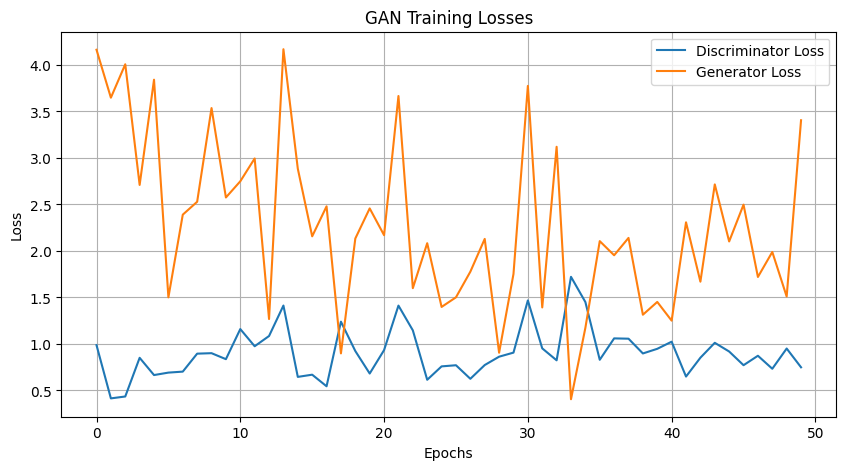

In [8]:
plt.figure(figsize=(10, 5))
plt.plot(d_losses, label="Discriminator Loss")
plt.plot(g_losses, label="Generator Loss")
plt.title("GAN Training Losses")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

## 5. Save Models
Save the state dictionaries of the trained models for evaluation in the next steps.

In [ ]:
torch.save(vae.state_dict(), "models/vae_cifar10.pth")
torch.save(generator.state_dict(), "models/gan_generator_cifar10.pth")
torch.save(discriminator.state_dict(), "models/gan_discriminator_cifar10.pth")

print("Models saved to 'models/' directory.")

Models saved to 'models/' directory.


# Step 2. Reconstruction vs Generation

In this step, we'll analyze and compare the outputs of the trained VAE and GAN. We will focus on visual quality, sample diversity, and quantitative metrics to understand their inherent trade-offs.

## Setup and Model Loading

### Hyperparameters

In [5]:
BATCH_SIZE = 128
LATENT_DIM = 128
IMG_CHANNELS = 3

### Load Trained Models and Data

In [6]:
# Load VAE
vae = VAE(img_channels=IMG_CHANNELS, latent_dim=LATENT_DIM).to(device)
vae.load_state_dict(torch.load("models/vae_cifar10.pth"))
vae.eval()

# Load GAN Generator
generator = Generator(latent_dim=LATENT_DIM, img_channels=IMG_CHANNELS).to(device)
generator.load_state_dict(torch.load("models/gan_generator_cifar10.pth"))
generator.eval()

# Load Test Data
transform = torchvision.transforms.Compose(
    [
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ]
)
test_dataset = torchvision.datasets.CIFAR10(
    root="./data", train=False, download=True, transform=transform
)
test_loader = torch.utils.data.DataLoader(
    dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=True
)

print("Models and test data loaded successfully.")

Models and test data loaded successfully.


## Visual Quality Comparison

### Generating a Side-by-Side Comparison
As suggested by the manual, we will visualize original test images, their VAE reconstructions, and random GAN samples to compare sharpness and realism.

VAE Reconstruction MSE on Test Batch: 0.0177


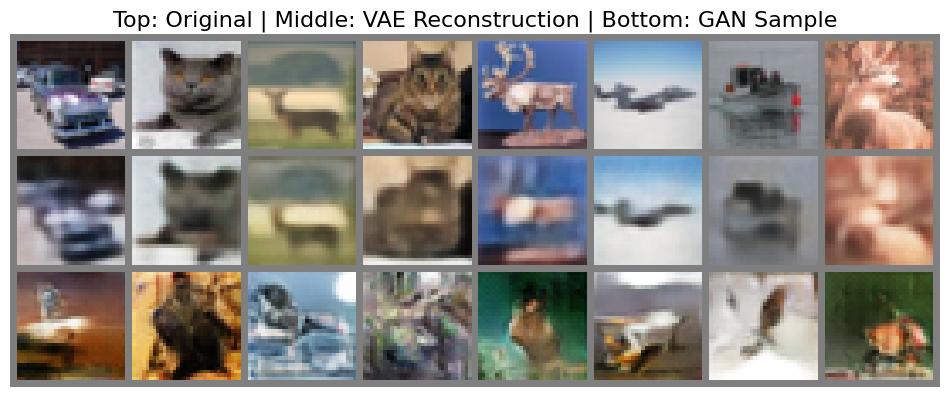

In [7]:
def imshow(imgs, title=""):
    imgs = imgs.clamp(-1, 1)  # Ensure data is in the valid range for unnormalization
    imgs = imgs / 2 + 0.5  # unnormalize
    npimgs = imgs.cpu().numpy()
    plt.figure(figsize=(12, 12))
    plt.imshow(np.transpose(npimgs, (1, 2, 0)))
    plt.title(title, fontsize=16)
    plt.axis("off")
    plt.show()


# Get a batch of real images
real_images, _ = next(iter(test_loader))
real_images = real_images.to(device)

# Generate VAE reconstructions
with torch.no_grad():
    vae_reconstructions, _, _ = vae.reconstruct(real_images, deterministic=True)

mse_loss = torch.nn.functional.mse_loss(
    vae_reconstructions, real_images, reduction="mean"
)
print(f"VAE Reconstruction MSE on Test Batch: {mse_loss.item():.4f}")

# Generate GAN samples
with torch.no_grad():
    noise = torch.randn(real_images.size(0), LATENT_DIM, 1, 1, device=device)
    gan_samples = generator(noise)

# Select 8 images for a clean comparison grid
num_images_to_show = 8
originals = real_images[:num_images_to_show]
reconstructions = vae_reconstructions[:num_images_to_show]
generated = gan_samples[:num_images_to_show]

# Combine for display
comparison_grid = torch.cat([originals, reconstructions, generated])
grid = make_grid(comparison_grid, nrow=num_images_to_show)

imshow(grid, title="Top: Original | Middle: VAE Reconstruction | Bottom: GAN Sample")

## Sample Diversity Assessment

### Visualizing a Batch of Generated Images
To get a better sense of diversity and check for potential mode collapse in the GAN, we'll generate a larger grid of images from both models.

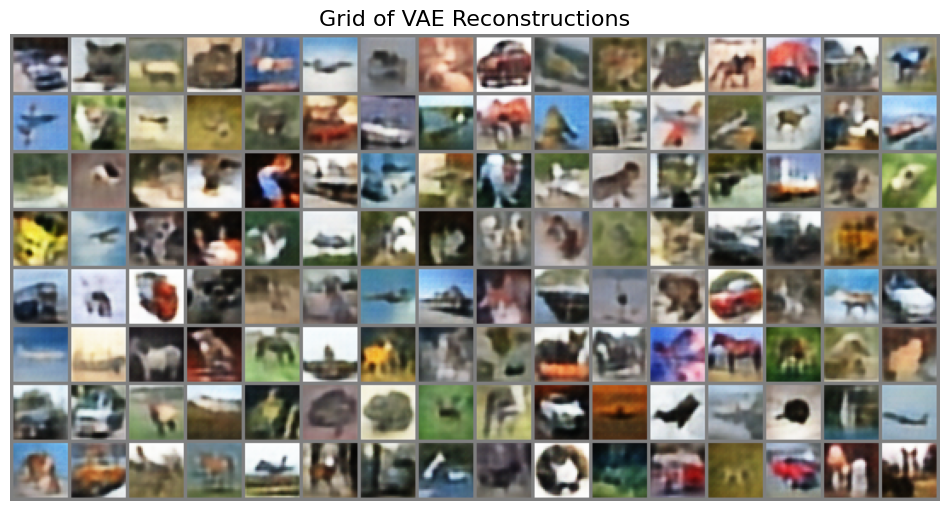

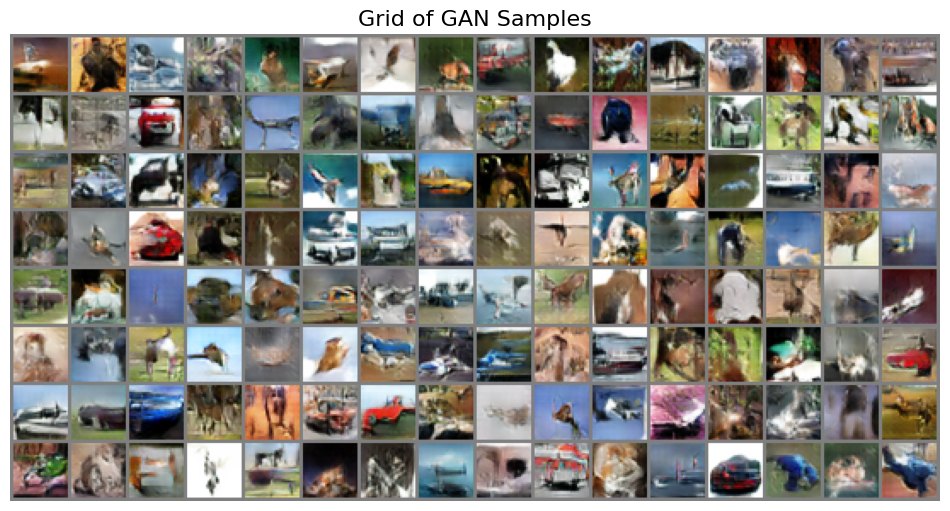

In [8]:
# VAE: Reconstruct a full batch to see diversity
grid_vae = make_grid(vae_reconstructions, nrow=16)
imshow(grid_vae, title=f"Grid of VAE Reconstructions")

# GAN: Generate a full batch to see diversity
grid_gan = make_grid(gan_samples, nrow=16)
imshow(grid_gan, title=f"Grid of GAN Samples")

## Quantitative Metric 1: Fréchet Inception Distance (FID)

### Calculating FID to Measure Perceptual Quality

In [9]:
# Create temporary directories for evaluation images
os.makedirs("eval_images/real", exist_ok=True)
os.makedirs("eval_images/vae", exist_ok=True)
os.makedirs("eval_images/gan", exist_ok=True)

NUM_SAMPLES_FOR_FID = 5000

# Save real test images
print(f"Saving {NUM_SAMPLES_FOR_FID} real images for FID calculation...")
for i, (img, _) in enumerate(test_dataset):
    if i >= NUM_SAMPLES_FOR_FID:
        break
    torchvision.utils.save_image(img, f"eval_images/real/{i}.png", normalize=True)

# Generate and save VAE and GAN images
print(f"Generating and saving {NUM_SAMPLES_FOR_FID} VAE and GAN images...")
with torch.no_grad():
    vae.eval()
    generator.eval()
    
    # Get a fixed set of real images for VAE reconstruction
    fixed_real_loader = torch.utils.data.DataLoader(
        test_dataset, batch_size=BATCH_SIZE, shuffle=False
    )

    saved_count = 0
    for real_batch, _ in fixed_real_loader:
        if saved_count >= NUM_SAMPLES_FOR_FID:
            break
        real_batch = real_batch.to(device)

        # VAE Reconstructions
        vae_imgs, _, _ = vae.reconstruct(real_batch, deterministic=True)

        # GAN Samples
        noise = torch.randn(real_batch.size(0), LATENT_DIM, 1, 1, device=device)
        gan_imgs = generator(noise)

        for j in range(real_batch.size(0)):
            if saved_count >= NUM_SAMPLES_FOR_FID:
                break
            torchvision.utils.save_image(
                vae_imgs[j], f"eval_images/vae/{saved_count}.png", normalize=True
            )
            torchvision.utils.save_image(
                gan_imgs[j], f"eval_images/gan/{saved_count}.png", normalize=True
            )
            saved_count += 1

# Calculate FID for VAE
metrics_vae = calculate_metrics(
    input1="eval_images/real",
    input2="eval_images/vae",
    cuda=torch.cuda.is_available(),
    isc=False,
    fid=True,
    kid=False,
    verbose=False,
)

# Calculate FID and Inception Score for GAN
metrics_gan = calculate_metrics(
    input1="eval_images/real",
    input2="eval_images/gan",
    cuda=torch.cuda.is_available(),
    isc=True,
    fid=True,
    kid=False,
    verbose=False,
)

print("\n--- Quantitative Results ---")
print(
    f"VAE Reconstruction FID Score (Lower is Better): {metrics_vae['frechet_inception_distance']:.2f}"
)
print(
    f"GAN Samples FID Score (Lower is Better): {metrics_gan['frechet_inception_distance']:.2f}"
)
print(
    f"GAN Samples Inception Score (Higher is Better): {metrics_gan['inception_score_mean']:.2f} ± {metrics_gan['inception_score_std']:.2f}"
)

Saving 5000 real images for FID calculation...


Generating and saving 5000 VAE and GAN images...

--- Quantitative Results ---
VAE Reconstruction FID Score (Lower is Better): 78.87
GAN Samples FID Score (Lower is Better): 48.18
GAN Samples Inception Score (Higher is Better): 10.53 ± 0.35


## Quantitative Metric 2: Class Diversity Analysis

### Using a Pre-trained Classifier to Assess Mode Coverage



CIFAR-10 ResNet-50 classifier loaded successfully.
Generating 1000 samples from each model for diversity check...


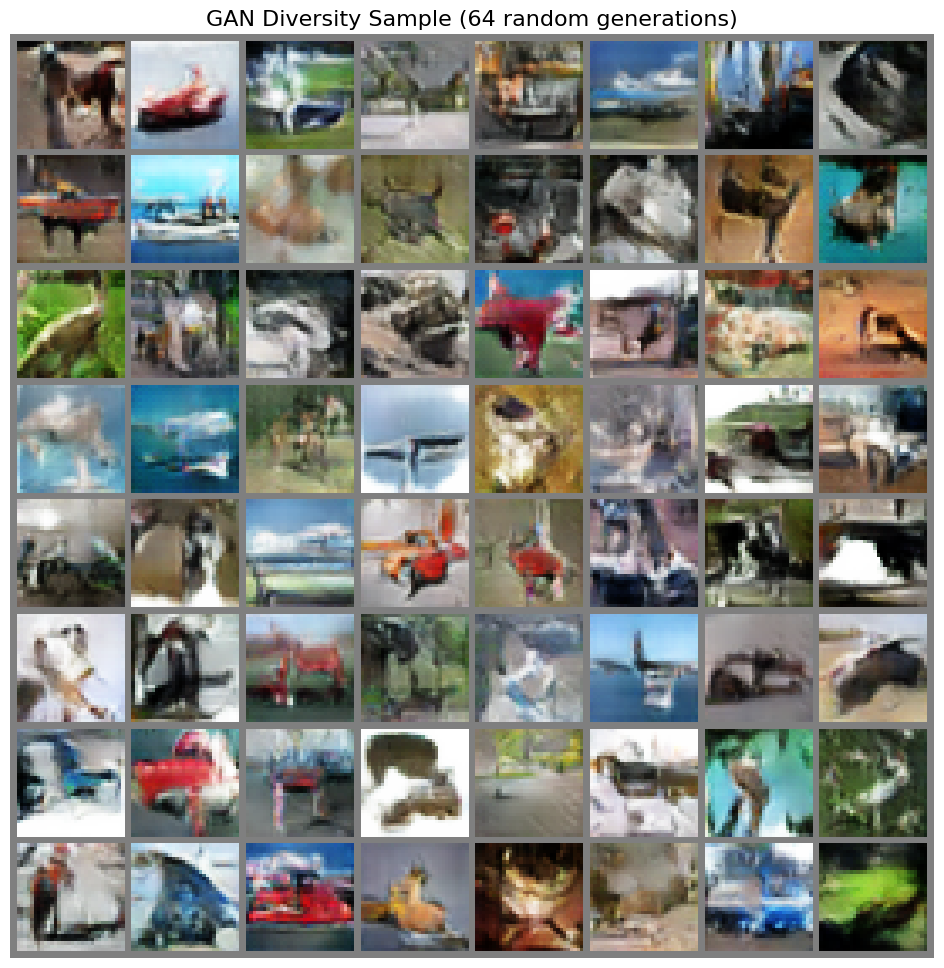

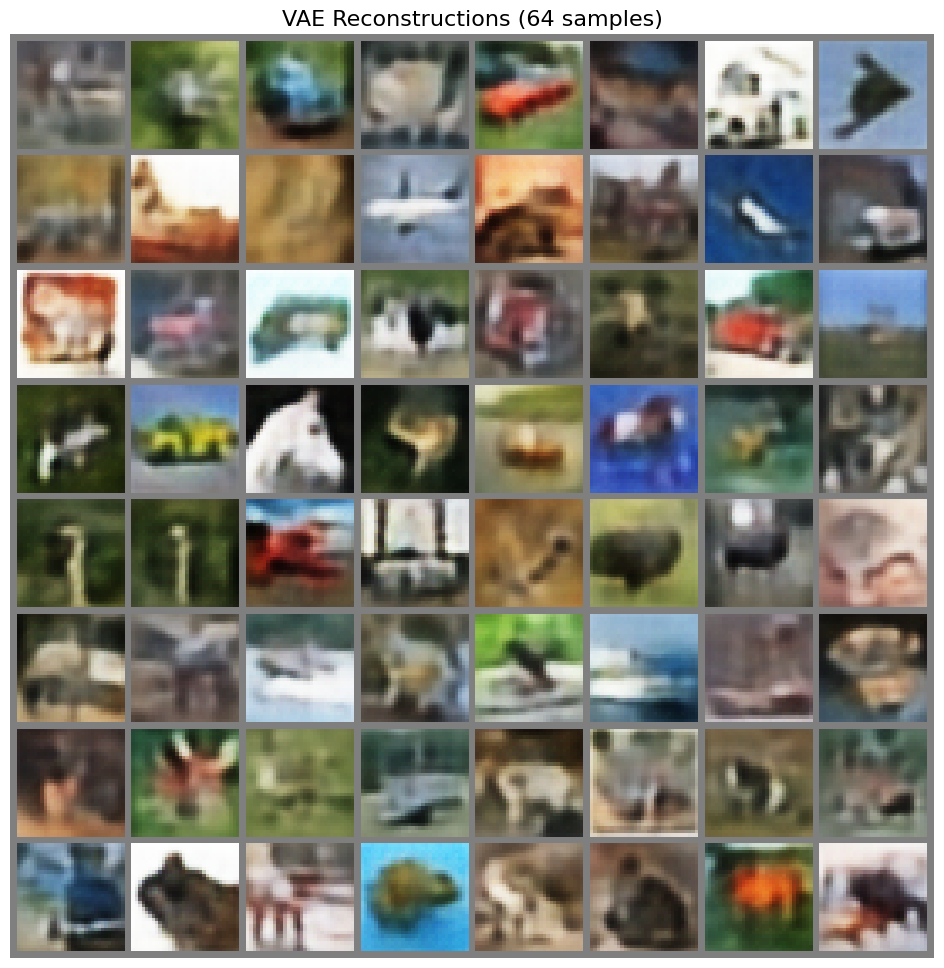

Testing first 8 samples that went to classifier:

--- VAE Samples ---


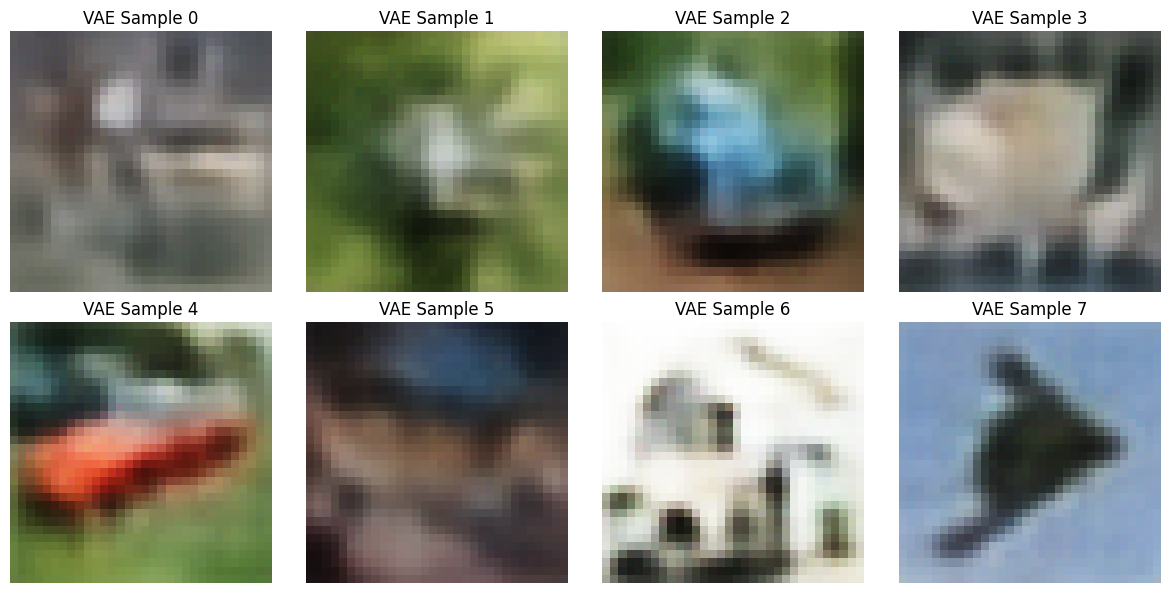

VAE predicted classes for these 8 samples: ['deer', 'bird', 'frog', 'dog', 'automobile', 'dog', 'dog', 'airplane']

--- GAN Samples ---


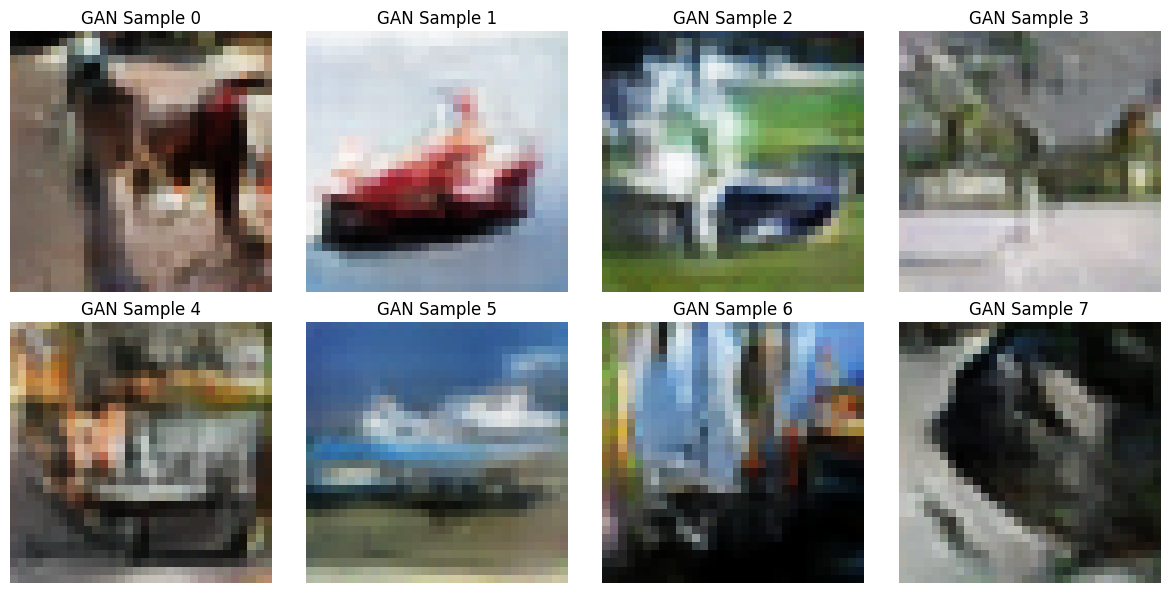

GAN predicted classes for these 8 samples: ['horse', 'ship', 'airplane', 'airplane', 'truck', 'airplane', 'truck', 'cat']

GAN Class Distribution:
- Covers 10/10 CIFAR-10 classes
- Classes found: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
- Class frequencies: [196, 76, 74, 147, 72, 62, 131, 74, 75, 93]

VAE Class Distribution:
- Covers 10/10 CIFAR-10 classes
- Classes found: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
- Class frequencies: [84, 54, 80, 272, 38, 263, 41, 51, 87, 30]

--- Automated Class Distribution Summary ---
GAN covers 10/10 classes
VAE covers 10/10 classes

--- Detailed Class Distribution Comparison ---
Class        Test %   GAN Count  GAN %    VAE Count  VAE %   
----------------------------------------------------------------------
airplane     10.0     196        19.6     84         8.4     
automobile   10.0     76         7.6      54         5.4     
bird         10.0     74         7.4      80         8.0     
cat          10.0     147        14.7     272        27.2    
deer         1

In [10]:
# Load pre-trained CIFAR-10 classifier for automated class counting


def get_cifar10_classifier():
    """
    Create the exact ResNet-50 architecture used in the GitHub repo
    """

    # Use the exact same architecture as the GitHub code
    class CIFAR10_ResNet(nn.Module):
        def __init__(self, block, layers, num_classes=10):
            super(CIFAR10_ResNet, self).__init__()
            self.inplanes = 64

            # CIFAR-10 specific first layer (from GitHub code)
            self.conv1 = nn.Conv2d(
                3, 64, kernel_size=3, stride=1, padding=1, bias=False
            )
            self.bn1 = nn.BatchNorm2d(64)
            self.relu = nn.ReLU(inplace=True)
            self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

            # Standard ResNet layers
            self.layer1 = self._make_layer(block, 64, layers[0])
            self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
            self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
            self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
            self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
            self.fc = nn.Linear(512 * block.expansion, num_classes)

        def _make_layer(self, block, planes, blocks, stride=1):
            downsample = None
            if stride != 1 or self.inplanes != planes * block.expansion:
                downsample = nn.Sequential(
                    nn.Conv2d(
                        self.inplanes,
                        planes * block.expansion,
                        kernel_size=1,
                        stride=stride,
                        bias=False,
                    ),
                    nn.BatchNorm2d(planes * block.expansion),
                )

            layers = []
            layers.append(block(self.inplanes, planes, stride, downsample))
            self.inplanes = planes * block.expansion
            for _ in range(1, blocks):
                layers.append(block(self.inplanes, planes))

            return nn.Sequential(*layers)

        def forward(self, x):
            x = self.conv1(x)
            x = self.bn1(x)
            x = self.relu(x)
            x = self.maxpool(x)

            x = self.layer1(x)
            x = self.layer2(x)
            x = self.layer3(x)
            x = self.layer4(x)

            x = self.avgpool(x)
            x = x.reshape(x.size(0), -1)
            x = self.fc(x)
            return x

    return CIFAR10_ResNet(Bottleneck, [3, 4, 6, 3], num_classes=10)


try:
    classifier = get_cifar10_classifier()
    classifier.load_state_dict(torch.load("models/resnet50.pt", map_location=device))
    classifier.to(device)
    classifier.eval()
    print("\nCIFAR-10 ResNet-50 classifier loaded successfully.")
    use_classifier = True
except:
    print(
        "\nCIFAR-10 classifier not available. Using manual diversity assessment only."
    )
    use_classifier = False


def count_unique_classes_automated(samples, classifier, model_name):
    """
    Use classifier to count unique classes in generated samples
    """
    with torch.no_grad():
        samples = prep_for_cifar_resnet(samples)
        predictions = classifier(samples)
        predicted_classes = predictions.argmax(dim=1)
        unique_classes = torch.unique(predicted_classes)

        print(f"\n{model_name} Class Distribution:")
        print(f"- Covers {len(unique_classes)}/10 CIFAR-10 classes")
        print(f"- Classes found: {unique_classes.tolist()}")

        # Count frequency of each class
        class_counts = torch.bincount(predicted_classes, minlength=10)
        print(f"- Class frequencies: {class_counts.tolist()}")

        return len(unique_classes), unique_classes, class_counts


def check_class_diversity_simple(num_samples=1000):
    """
    Generate samples and assess class distribution diversity
    """
    print(f"Generating {num_samples} samples from each model for diversity check...")

    with torch.no_grad():
        generator.eval()
        # GAN samples
        noise = torch.randn(num_samples, LATENT_DIM, 1, 1, device=device)
        gan_samples = generator(noise)

        # VAE reconstructions - need to get real images first
        vae.eval()
        vae_samples = []
        samples_collected = 0

        for real_batch, _ in test_loader:
            if samples_collected >= num_samples:
                break
            real_batch = real_batch.to(device)
            batch_reconstructions, _, _ = vae.reconstruct(real_batch, deterministic=True)
            vae_samples.append(batch_reconstructions)
            samples_collected += real_batch.size(0)

        vae_samples = torch.cat(vae_samples, dim=0)[:num_samples]

    # Create grids for visual diversity assessment
    gan_grid = make_grid(gan_samples[:64], nrow=8)
    vae_grid = make_grid(vae_samples[:64], nrow=8)

    imshow(gan_grid, title="GAN Diversity Sample (64 random generations)")
    imshow(vae_grid, title="VAE Reconstructions (64 samples)")

    return gan_samples, vae_samples

def prep_for_cifar_resnet(x_minus1_1: torch.Tensor) -> torch.Tensor:
    # [-1,1] -> [0,1]
    x01 = (x_minus1_1 + 1.0) / 2.0
    mean = torch.tensor([0.4914, 0.4822, 0.4465], device=x01.device).view(1,3,1,1)
    std  = torch.tensor([0.2023, 0.1994, 0.2010], device=x01.device).view(1,3,1,1)
    return (x01 - mean) / std

# Run the diversity check
gan_diversity_samples, vae_diversity_samples = check_class_diversity_simple()

# Test if classifier and visual samples match for both models
print("Testing first 8 samples that went to classifier:")

# Show VAE samples
print("\n--- VAE Samples ---")
vae_test_samples = vae_diversity_samples[:8]
fig, axes = plt.subplots(2, 4, figsize=(12, 6))
for i in range(8):
    img = vae_test_samples[i].cpu() / 2 + 0.5  # Unnormalize
    axes[i // 4, i % 4].imshow(np.transpose(img.numpy(), (1, 2, 0)))
    axes[i // 4, i % 4].set_title(f"VAE Sample {i}")
    axes[i // 4, i % 4].axis("off")
plt.tight_layout()
plt.show()

CIFAR10_CLASSES = [
    "airplane",
    "automobile",
    "bird",
    "cat",
    "deer",
    "dog",
    "frog",
    "horse",
    "ship",
    "truck",
]

# Get classifier predictions for VAE samples
with torch.no_grad():
    vae_preds = classifier(prep_for_cifar_resnet(vae_test_samples))
    vae_pred_classes = vae_preds.argmax(dim=1)

vae_class_names = [CIFAR10_CLASSES[i] for i in vae_pred_classes]
print("VAE predicted classes for these 8 samples:", vae_class_names)

# Show GAN samples
print("\n--- GAN Samples ---")
gan_test_samples = gan_diversity_samples[:8]
fig, axes = plt.subplots(2, 4, figsize=(12, 6))
for i in range(8):
    img = gan_test_samples[i].cpu() / 2 + 0.5  # Unnormalize
    axes[i // 4, i % 4].imshow(np.transpose(img.numpy(), (1, 2, 0)))
    axes[i // 4, i % 4].set_title(f"GAN Sample {i}")
    axes[i // 4, i % 4].axis("off")
plt.tight_layout()
plt.show()

# Get classifier predictions for GAN samples
with torch.no_grad():
    gan_preds = classifier(prep_for_cifar_resnet(gan_test_samples))
    gan_pred_classes = gan_preds.argmax(dim=1)

gan_class_names = [CIFAR10_CLASSES[i] for i in gan_pred_classes]
print("GAN predicted classes for these 8 samples:", gan_class_names)

# Analyze class distribution for both models using the resnet classifier
if use_classifier:
    gan_class_count, gan_classes, gan_freq = count_unique_classes_automated(
        gan_diversity_samples, classifier, "GAN"
    )
    vae_class_count, vae_classes, vae_freq = count_unique_classes_automated(
        vae_diversity_samples, classifier, "VAE"
    )

    print(f"\n--- Automated Class Distribution Summary ---")
    print(f"GAN covers {gan_class_count}/10 classes")
    print(f"VAE covers {vae_class_count}/10 classes")

    # Check actual test set class distribution
    test_class_counts = torch.bincount(
        torch.tensor([label for _, label in test_dataset]), minlength=10
    )
    test_percentages = test_class_counts.float() / len(test_dataset) * 100

    # Create detailed comparison table with test set distribution
    print(f"\n--- Detailed Class Distribution Comparison ---")
    print(
        f"{'Class':<12} {'Test %':<8} {'GAN Count':<10} {'GAN %':<8} {'VAE Count':<10} {'VAE %':<8}"
    )
    print("-" * 70)

    for i in range(10):
        test_pct = test_percentages[i].item()
        gan_count = gan_freq[i].item()
        vae_count = vae_freq[i].item()
        gan_pct = (gan_count / 1000) * 100
        vae_pct = (vae_count / 1000) * 100

        print(
            f"{CIFAR10_CLASSES[i]:<12} {test_pct:<8.1f} {gan_count:<10} {gan_pct:<8.1f} {vae_count:<10} {vae_pct:<8.1f}"
        )
else:
    print(f"\n--- Manual Assessment Required ---")
    print("Please visually inspect the diversity grids above to assess class coverage.")

# Clean up the saved images
shutil.rmtree("eval_images")